In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from tqdm.notebook import tqdm

import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from src.signal_categories import topological_category_labels, topological_category_colors
from src.signal_categories import physics_category_labels, physics_category_colors
from src.signal_categories import filetype_category_labels, filetype_category_colors


In [2]:
import umap
import sklearn
from sklearn.preprocessing import StandardScaler

from sklearn.manifold import TSNE, MDS, Isomap
from sklearn.decomposition import PCA, FastICA, NMF
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from src.file_locations import intermediate_files_location

print(f"sklearn version: {sklearn.__version__}")
print(f"umap version: {umap.__version__}")


sklearn version: 1.6.1
umap version: 0.5.9.post2


In [ ]:
#training = "first_combined_training"
training = "first_wc_training"
#training = "first_lantern_training"


# File Loading

In [4]:
print("loading all_df.pkl...")
with open(f"{intermediate_files_location}/all_df.pkl", "rb") as f:
    all_df = pickle.load(f)
print(f"{all_df.shape=}")

# this only includes predictions for events passing the preselection used during training
print("loading predictions.pkl...")
with open(f"../training_outputs/{training}/predictions.pkl", "rb") as f:
    pred_df = pickle.load(f)
print(f"{pred_df.shape=}")

print("merging all_df and predictions.pkl...")
merged_df = pd.merge(all_df, pred_df, on=["filetype", "run", "subrun", "event"], how="left")

sig_categories = topological_category_labels

prob_categories = ["prob_" + cat for cat in sig_categories]

for prob in prob_categories:
    merged_df[prob] = merged_df[prob].fillna(-1)

num_train_events = len(merged_df.query("used_for_training == True"))
num_test_events = len(merged_df.query("used_for_testing == True"))
frac_test = num_test_events / (num_train_events + num_test_events)
print(f"weighting up by the fraction of test events: {frac_test:.3f}")

modified_net_weights = []
used_for_testing = merged_df["used_for_testing"].to_numpy()
wc_net_weights = merged_df["wc_net_weight"].to_numpy()
for i in range(len(merged_df)):
    if used_for_testing[i]:
        modified_net_weights.append(wc_net_weights[i] / frac_test)
    else:
        modified_net_weights.append(wc_net_weights[i])
merged_df["wc_net_weight"] = modified_net_weights         

merged_df = merged_df.query("used_for_testing == True")

print(f"{merged_df.shape=}")
presel_merged_df = merged_df.query("wc_kine_reco_Enu > 0 and wc_shw_sp_n_20mev_showers > 0")
print(f"{presel_merged_df.shape=}")

presel_merged_df


loading all_df.pkl...
all_df.shape=(2171921, 193)
loading predictions.pkl...
pred_df.shape=(356805, 22)
merging all_df and predictions.pkl...
weighting up by the fraction of test events: 0.500
merged_df.shape=(178403, 211)
presel_merged_df.shape=(178403, 211)


,wc_match_isFC,wc_numu_score,wc_nc_delta_score,wc_shw_sp_n_20mev_showers,wc_nue_score,wc_nc_pio_score,wc_kine_reco_Enu,wc_truth_NprimPio,wc_truth_NCDelta,wc_reco_nuvtxX,...,prob_2g0p,prob_2gNp1mu,prob_2g0p1mu,prob_2g_outFV,prob_1eNp,prob_1e0p,prob_0g,prob_3plusg,prob_dirt,prob_ext
7,True,-1.043858,-3.831858,1.0,-15.000000,-1.320506,72.947304,0.0,0.0,154.227982,...,0.032471,0.015362,0.007168,0.014072,0.000871,0.000455,0.339159,0.007450,0.089818,0.433821
21,True,-0.710490,-2.425649,2.0,-4.049474,-3.169012,263.214722,0.0,0.0,173.298248,...,0.005555,0.009509,0.003957,0.007321,0.000315,0.000085,0.836274,0.003818,0.005076,0.095081
60,False,3.305738,-7.060031,2.0,-12.973451,-2.242356,976.803040,0.0,0.0,86.195633,...,0.000875,0.030049,0.005860,0.001111,0.000223,0.000109,0.941835,0.001722,0.000105,0.002157
71,True,1.362073,-7.687320,1.0,-9.857704,-3.127084,805.092773,1.0,0.0,147.656448,...,0.000382,0.029592,0.004946,0.000627,0.000235,0.000088,0.948755,0.001692,0.000085,0.001139
83,False,0.210693,-7.675740,1.0,-9.418540,-3.721158,123.078445,0.0,0.0,172.637375,...,0.003857,0.013925,0.002996,0.002573,0.004243,0.000212,0.929071,0.001694,0.001567,0.014993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2171909,True,0.011210,-3.048556,1.0,-15.000000,2.423527,583.533447,1.0,0.0,39.574425,...,0.227284,0.047398,0.016398,0.005095,0.000136,0.000082,0.000749,0.011623,0.000726,0.012315
2171910,True,2.189116,-8.056780,1.0,-15.000000,-1.537735,2034.660156,1.0,0.0,74.242462,...,0.008465,0.696165,0.092918,0.009905,0.000402,0.000213,0.001074,0.062924,0.000174,0.001249
2171916,True,-0.144581,-5.947532,4.0,-9.097902,2.330691,990.763000,1.0,0.0,107.434372,...,0.032471,0.015362,0.007168,0.014072,0.000871,0.000455,0.339159,0.007450,0.089818,0.433821
2171917,True,-0.760487,-2.502663,1.0,-15.000000,1.098346,367.168182,1.0,0.0,83.713882,...,0.014572,0.009036,0.004660,0.006534,0.000355,0.000180,0.788271,0.003931,0.028550,0.105543


In [5]:
probs_2d_arr = presel_merged_df[prob_categories].to_numpy()

reco_categories_argmax = np.argmax(probs_2d_arr, axis=1)

presel_merged_df["reco_category_argmax_index"] = reco_categories_argmax


# Multi-Class Probability Visualization

In [6]:
#scaler = StandardScaler()
#probs_scaled = scaler.fit_transform(probs_2d_arr)
probs_scaled = probs_2d_arr

reducer = umap.UMAP(random_state=42)

reducer.fit(probs_scaled)
umap_result = reducer.transform(probs_scaled)


/nevis/houston/home/leehagaman/uv_base/lib64/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


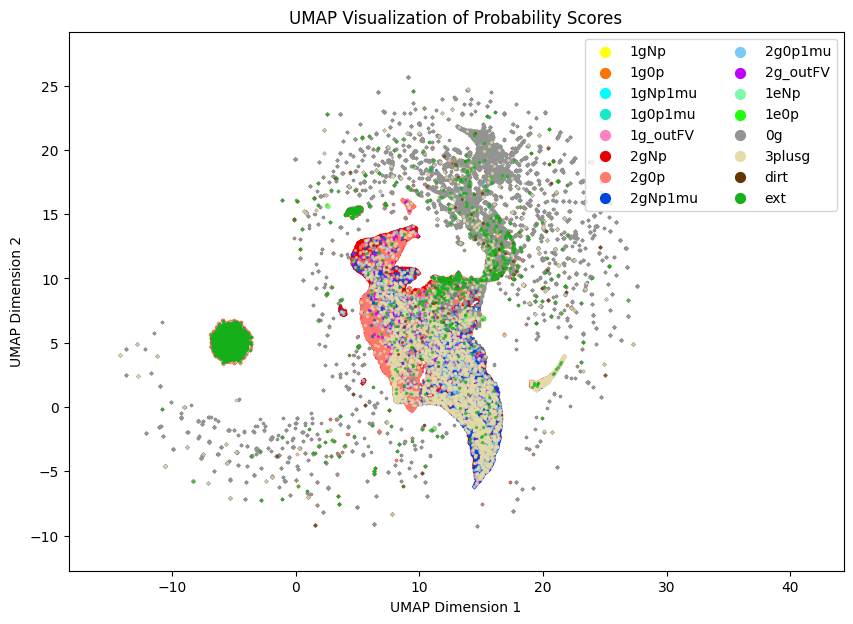

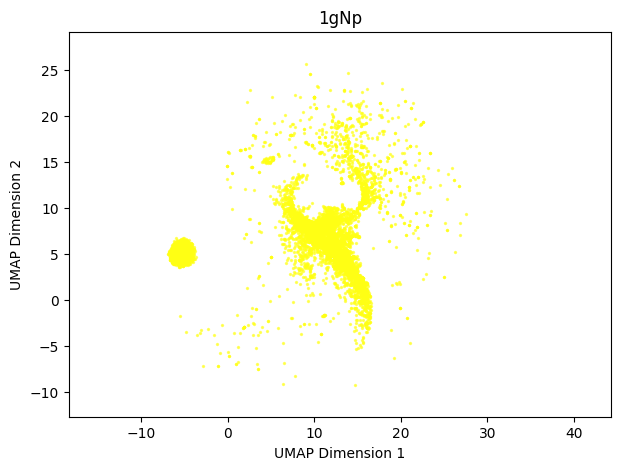

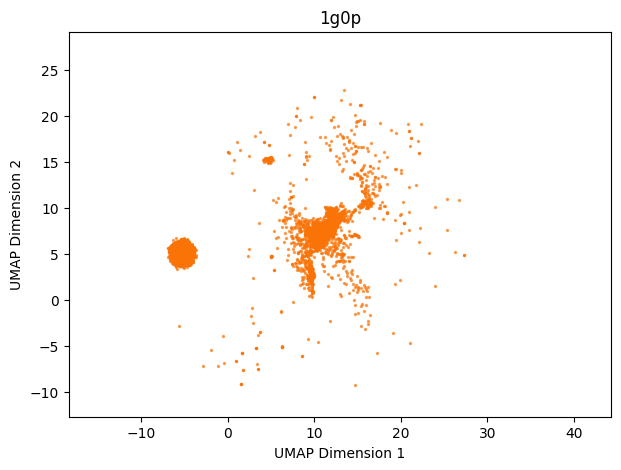

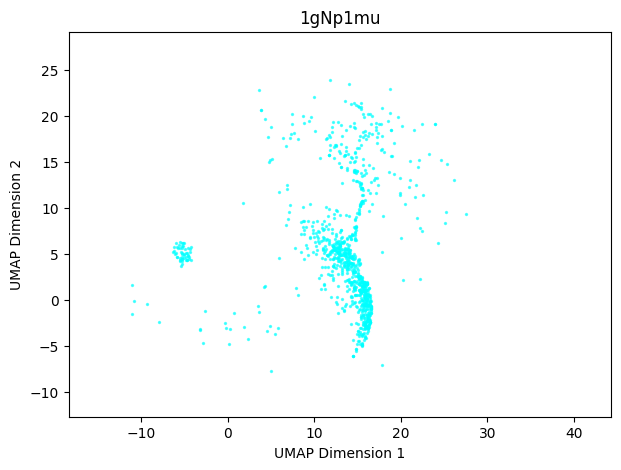

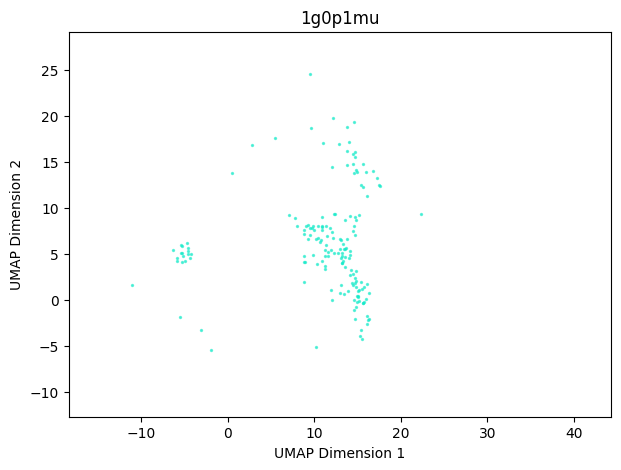

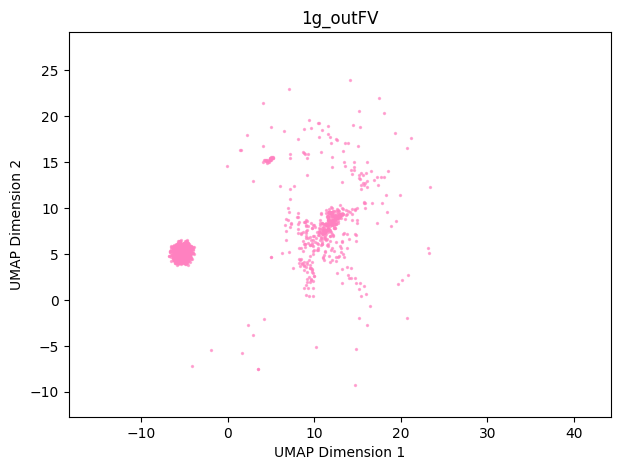

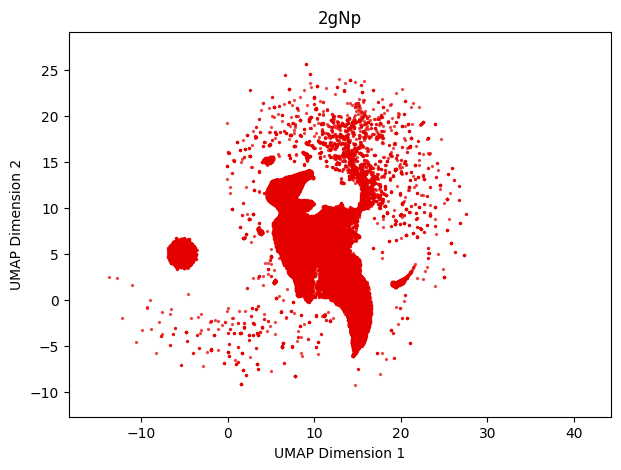

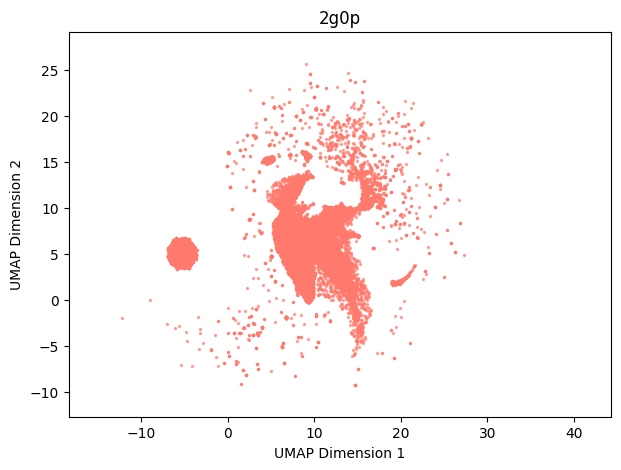

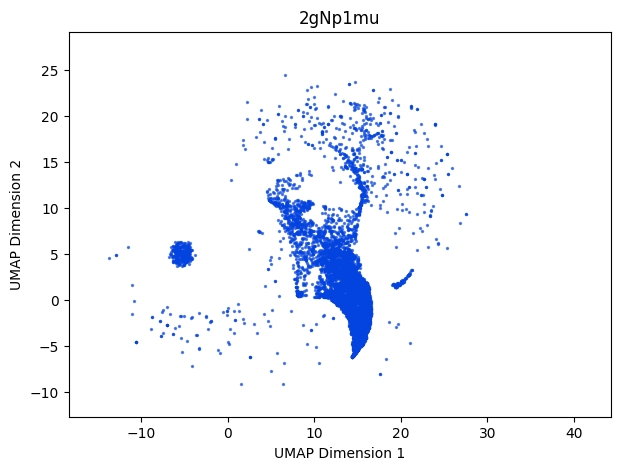

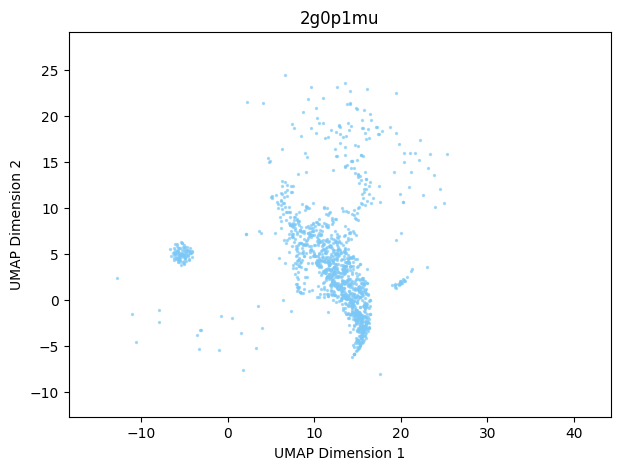

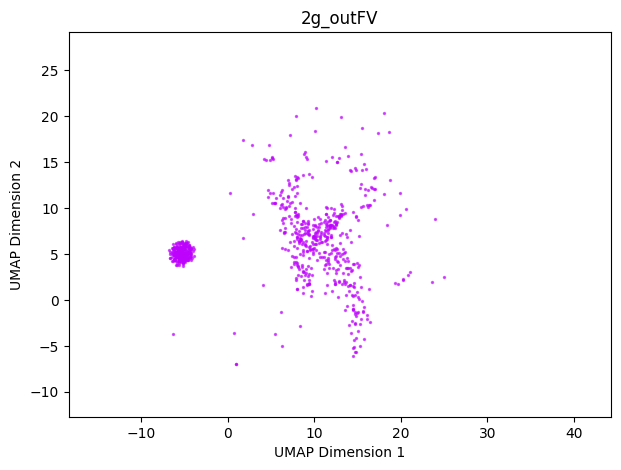

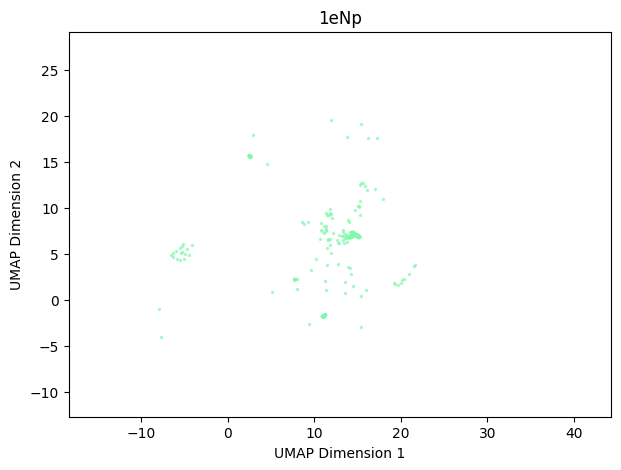

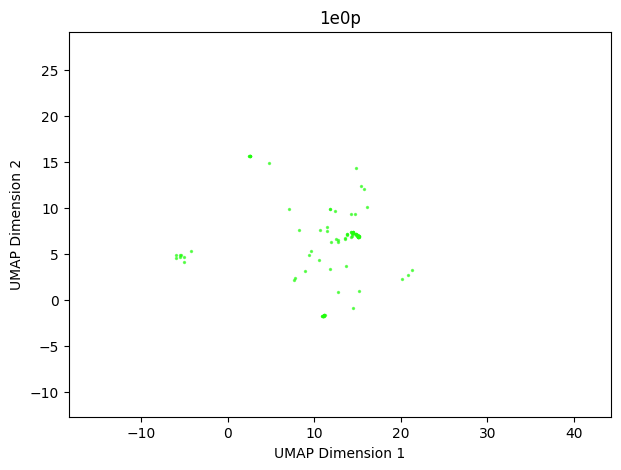

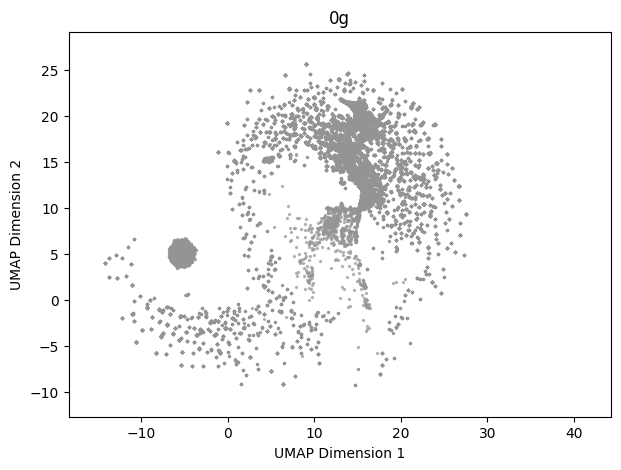

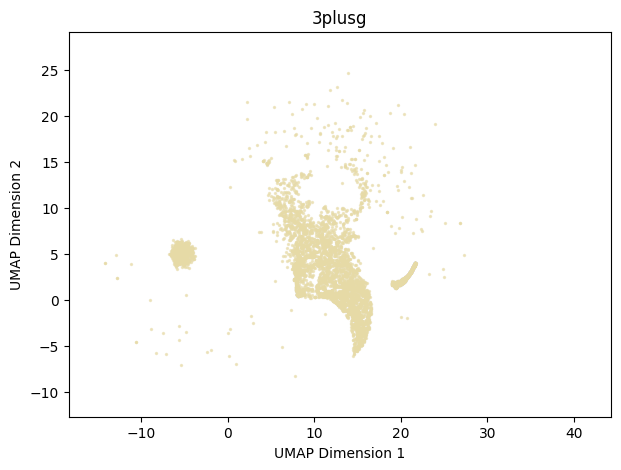

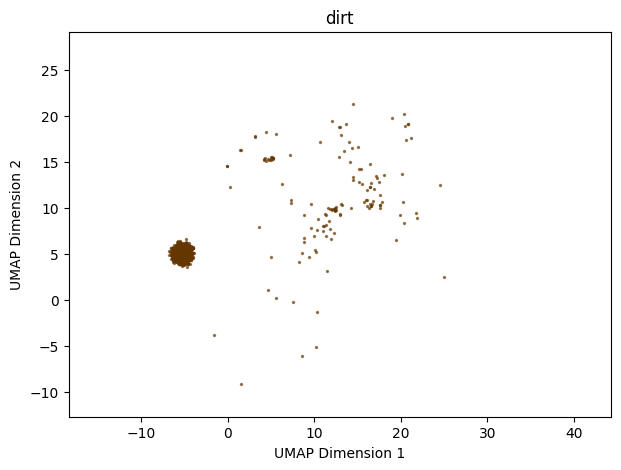

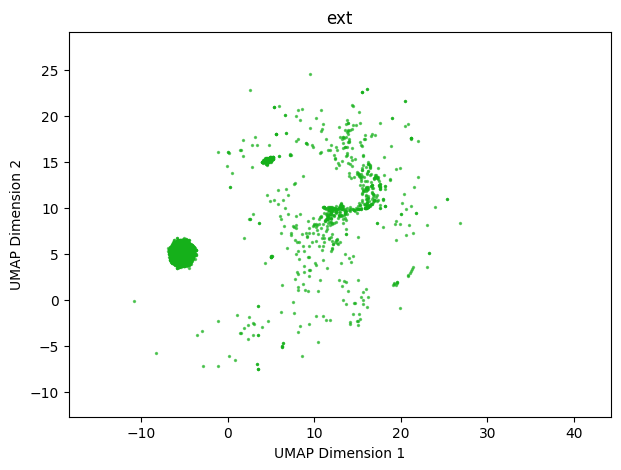

In [7]:
true_sig_categories = presel_merged_df["topological_signal_category"].to_numpy()
plt.figure(figsize=(10, 7))
for i in range(len(sig_categories)):
    true_sig_category_mask = true_sig_categories == sig_categories[i]
    plt.scatter(umap_result[true_sig_category_mask, 0], umap_result[true_sig_category_mask, 1], alpha=0.6, s=2, c=topological_category_colors[i])
    plt.scatter([], [], s=50, c=topological_category_colors[i], label=sig_categories[i])
plt.title('UMAP Visualization of Probability Scores')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
min_x, max_x = umap_result[:, 0].min(), umap_result[:, 0].max()
min_y, max_y = umap_result[:, 1].min(), umap_result[:, 1].max()
x_diff = max_x - min_x
y_diff = max_y - min_y
plt.xlim(min_x - x_diff * 0.1, max_x + x_diff * 0.4)
plt.ylim(min_y - y_diff * 0.1, max_y + y_diff * 0.1)
plt.legend(loc="upper right", ncol=2)
plt.savefig(f"../training_outputs/{training}/score_vis/umap_visualization.png")

for i in range(len(sig_categories)):
    plt.figure(figsize=(7, 5))
    true_sig_category_mask = true_sig_categories == sig_categories[i]
    plt.scatter(umap_result[true_sig_category_mask, 0], umap_result[true_sig_category_mask, 1], alpha=0.6, s=2, c=topological_category_colors[i])
    plt.scatter([], [], s=50, c=topological_category_colors[i], label=sig_categories[i])
    plt.title(sig_categories[i])
    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')
    min_x, max_x = umap_result[:, 0].min(), umap_result[:, 0].max()
    min_y, max_y = umap_result[:, 1].min(), umap_result[:, 1].max()
    x_diff = max_x - min_x
    y_diff = max_y - min_y
    plt.xlim(min_x - x_diff * 0.1, max_x + x_diff * 0.4)
    plt.ylim(min_y - y_diff * 0.1, max_y + y_diff * 0.1)
    plt.savefig(f"../training_outputs/{training}/score_vis/{sig_categories[i]}_umap_visualization.png")


In [8]:
"""tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(probs_scaled)
plt.figure(figsize=(10, 7))
for i in range(len(sig_categories)):
    true_sig_category_mask = true_sig_categories == sig_categories[i]
    plt.scatter(tsne_result[true_sig_category_mask, 0], tsne_result[true_sig_category_mask, 1], alpha=0.6, s=10, c=topological_category_colors[i])
    plt.scatter([], [], s=50, c=topological_category_colors[i], label=sig_categories[i])
plt.title('t-SNE')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
min_x, max_x = tsne_result[:, 0].min(), tsne_result[:, 0].max()
min_y, max_y = tsne_result[:, 1].min(), tsne_result[:, 1].max()
x_diff = max_x - min_x
y_diff = max_y - min_y
plt.xlim(min_x - x_diff * 0.1, max_x + x_diff * 0.4)
plt.ylim(min_y - y_diff * 0.1, max_y + y_diff * 0.1)
plt.legend(loc="upper right", ncol=2)
plt.savefig(f"../training_outputs/{training}/score_vis/tsne_visualization.png")
"""

'tsne = TSNE(n_components=2, random_state=42)\ntsne_result = tsne.fit_transform(probs_scaled)\nplt.figure(figsize=(10, 7))\nfor i in range(len(sig_categories)):\n    true_sig_category_mask = true_sig_categories == sig_categories[i]\n    plt.scatter(tsne_result[true_sig_category_mask, 0], tsne_result[true_sig_category_mask, 1], alpha=0.6, s=10, c=topological_category_colors[i])\n    plt.scatter([], [], s=50, c=topological_category_colors[i], label=sig_categories[i])\nplt.title(\'t-SNE\')\nplt.xlabel(\'t-SNE Dimension 1\')\nplt.ylabel(\'t-SNE Dimension 2\')\nmin_x, max_x = tsne_result[:, 0].min(), tsne_result[:, 0].max()\nmin_y, max_y = tsne_result[:, 1].min(), tsne_result[:, 1].max()\nx_diff = max_x - min_x\ny_diff = max_y - min_y\nplt.xlim(min_x - x_diff * 0.1, max_x + x_diff * 0.4)\nplt.ylim(min_y - y_diff * 0.1, max_y + y_diff * 0.1)\nplt.legend(loc="upper right", ncol=2)\nplt.savefig(f"../training_outputs/{training}/score_vis/tsne_visualization.png")\n'

In [9]:
# too slow
"""
mds = MDS(n_components=2, random_state=42)
mds_result = mds.fit_transform(probs_scaled)
plt.figure(figsize=(10, 7))
for i in range(len(sig_categories)):
    true_sig_category_mask = true_sig_categories == sig_categories[i]
    plt.scatter(mds_result[true_sig_category_mask, 0], mds_result[true_sig_category_mask, 1], alpha=0.6, s=10, c=topological_category_colors[i])
    plt.scatter([], [], s=50, c=topological_category_colors[i], label=sig_categories[i])
plt.title('MDS')
plt.xlabel('MDS Dimension 1')
plt.ylabel('MDS Dimension 2')
min_x, max_x = mds_result[:, 0].min(), mds_result[:, 0].max()
min_y, max_y = mds_result[:, 1].min(), mds_result[:, 1].max()
x_diff = max_x - min_x
y_diff = max_y - min_y
plt.xlim(min_x - x_diff * 0.1, max_x + x_diff * 0.4)
plt.ylim(min_y - y_diff * 0.1, max_y + y_diff * 0.1)
plt.legend(loc="upper right", ncol=2)
plt.savefig(f"../training_outputs/{training}/mds_visualization.png")
"""
pass

In [10]:
"""pca = PCA(n_components=2, random_state=42)
pca_result = pca.fit_transform(probs_scaled)
plt.figure(figsize=(10, 7))
for i in range(len(sig_categories)):
    true_sig_category_mask = true_sig_categories == sig_categories[i]
    plt.scatter(pca_result[true_sig_category_mask, 0], pca_result[true_sig_category_mask, 1], alpha=0.6, s=10, c=topological_category_colors[i])
    plt.scatter([], [], s=50, c=topological_category_colors[i], label=sig_categories[i])
plt.title('PCA')
plt.xlabel('PCA Dimension 1')
plt.ylabel('PCA Dimension 2')
min_x, max_x = pca_result[:, 0].min(), pca_result[:, 0].max()
min_y, max_y = pca_result[:, 1].min(), pca_result[:, 1].max()
x_diff = max_x - min_x
y_diff = max_y - min_y
plt.xlim(min_x - x_diff * 0.1, max_x + x_diff * 0.4)
plt.ylim(min_y - y_diff * 0.1, max_y + y_diff * 0.1)
plt.legend(loc="upper right", ncol=2)
plt.savefig(f"../training_outputs/{training}/score_vis/pca_visualization.png")
"""

'pca = PCA(n_components=2, random_state=42)\npca_result = pca.fit_transform(probs_scaled)\nplt.figure(figsize=(10, 7))\nfor i in range(len(sig_categories)):\n    true_sig_category_mask = true_sig_categories == sig_categories[i]\n    plt.scatter(pca_result[true_sig_category_mask, 0], pca_result[true_sig_category_mask, 1], alpha=0.6, s=10, c=topological_category_colors[i])\n    plt.scatter([], [], s=50, c=topological_category_colors[i], label=sig_categories[i])\nplt.title(\'PCA\')\nplt.xlabel(\'PCA Dimension 1\')\nplt.ylabel(\'PCA Dimension 2\')\nmin_x, max_x = pca_result[:, 0].min(), pca_result[:, 0].max()\nmin_y, max_y = pca_result[:, 1].min(), pca_result[:, 1].max()\nx_diff = max_x - min_x\ny_diff = max_y - min_y\nplt.xlim(min_x - x_diff * 0.1, max_x + x_diff * 0.4)\nplt.ylim(min_y - y_diff * 0.1, max_y + y_diff * 0.1)\nplt.legend(loc="upper right", ncol=2)\nplt.savefig(f"../training_outputs/{training}/score_vis/pca_visualization.png")\n'

In [11]:
# too slow
"""
isomap = Isomap(n_components=2, n_neighbors=10)
isomap_result = isomap.fit_transform(probs_scaled)
plt.figure(figsize=(10, 7))
for i in range(len(sig_categories)):
    true_sig_category_mask = true_sig_categories == sig_categories[i]
    plt.scatter(isomap_result[true_sig_category_mask, 0], isomap_result[true_sig_category_mask, 1], alpha=0.6, s=10, c=topological_category_colors[i])
    plt.scatter([], [], s=50, c=topological_category_colors[i], label=sig_categories[i])
plt.title('Isomap')
plt.xlabel('Isomap Dimension 1')
plt.ylabel('Isomap Dimension 2')
min_x, max_x = isomap_result[:, 0].min(), isomap_result[:, 0].max()
min_y, max_y = isomap_result[:, 1].min(), isomap_result[:, 1].max()
x_diff = max_x - min_x
y_diff = max_y - min_y
plt.xlim(min_x - x_diff * 0.1, max_x + x_diff * 0.4)
plt.ylim(min_y - y_diff * 0.1, max_y + y_diff * 0.1)
plt.legend(loc="upper right", ncol=2)
plt.savefig(f"../training_outputs/{training}/score_vis/isomap_visualization.png")
"""
pass

In [12]:
"""fastica = FastICA(n_components=2, random_state=42)
fastica_result = fastica.fit_transform(probs_scaled)
plt.figure(figsize=(10, 7))
for i in range(len(sig_categories)):
    true_sig_category_mask = true_sig_categories == sig_categories[i]
    plt.scatter(fastica_result[true_sig_category_mask, 0], fastica_result[true_sig_category_mask, 1], alpha=0.6, s=10, c=topological_category_colors[i])
    plt.scatter([], [], s=50, c=topological_category_colors[i], label=sig_categories[i])
plt.title('FastICA')
plt.xlabel('FastICA Dimension 1')
plt.ylabel('FastICA Dimension 2')
min_x, max_x = fastica_result[:, 0].min(), fastica_result[:, 0].max()
min_y, max_y = fastica_result[:, 1].min(), fastica_result[:, 1].max()
x_diff = max_x - min_x
y_diff = max_y - min_y
plt.xlim(min_x - x_diff * 0.1, max_x + x_diff * 0.5)
plt.ylim(min_y - y_diff * 0.1, max_y + y_diff * 0.1)
plt.legend(loc="upper right", ncol=2)
plt.savefig(f"../training_outputs/{training}/score_vis/fastica_visualization.png")
"""

'fastica = FastICA(n_components=2, random_state=42)\nfastica_result = fastica.fit_transform(probs_scaled)\nplt.figure(figsize=(10, 7))\nfor i in range(len(sig_categories)):\n    true_sig_category_mask = true_sig_categories == sig_categories[i]\n    plt.scatter(fastica_result[true_sig_category_mask, 0], fastica_result[true_sig_category_mask, 1], alpha=0.6, s=10, c=topological_category_colors[i])\n    plt.scatter([], [], s=50, c=topological_category_colors[i], label=sig_categories[i])\nplt.title(\'FastICA\')\nplt.xlabel(\'FastICA Dimension 1\')\nplt.ylabel(\'FastICA Dimension 2\')\nmin_x, max_x = fastica_result[:, 0].min(), fastica_result[:, 0].max()\nmin_y, max_y = fastica_result[:, 1].min(), fastica_result[:, 1].max()\nx_diff = max_x - min_x\ny_diff = max_y - min_y\nplt.xlim(min_x - x_diff * 0.1, max_x + x_diff * 0.5)\nplt.ylim(min_y - y_diff * 0.1, max_y + y_diff * 0.1)\nplt.legend(loc="upper right", ncol=2)\nplt.savefig(f"../training_outputs/{training}/score_vis/fastica_visualization

In [13]:
"""nmf = NMF(n_components=2, random_state=42)
nmf_result = nmf.fit_transform(probs_scaled)
plt.figure(figsize=(10, 7))
for i in range(len(sig_categories)):
    true_sig_category_mask = true_sig_categories == sig_categories[i]
    plt.scatter(nmf_result[true_sig_category_mask, 0], nmf_result[true_sig_category_mask, 1], alpha=0.6, s=10, c=topological_category_colors[i])
    plt.scatter([], [], s=50, c=topological_category_colors[i], label=sig_categories[i])
plt.title('NMF')
plt.xlabel('NMF Dimension 1')
plt.ylabel('NMF Dimension 2')
min_x, max_x = nmf_result[:, 0].min(), nmf_result[:, 0].max()
min_y, max_y = nmf_result[:, 1].min(), nmf_result[:, 1].max()
x_diff = max_x - min_x
y_diff = max_y - min_y
plt.xlim(min_x - x_diff * 0.1, max_x + x_diff * 0.4)
plt.ylim(min_y - y_diff * 0.1, max_y + y_diff * 0.1)
plt.legend(loc="upper right", ncol=2)
plt.savefig(f"../training_outputs/{training}/score_vis/nmf_visualization.png")
"""

'nmf = NMF(n_components=2, random_state=42)\nnmf_result = nmf.fit_transform(probs_scaled)\nplt.figure(figsize=(10, 7))\nfor i in range(len(sig_categories)):\n    true_sig_category_mask = true_sig_categories == sig_categories[i]\n    plt.scatter(nmf_result[true_sig_category_mask, 0], nmf_result[true_sig_category_mask, 1], alpha=0.6, s=10, c=topological_category_colors[i])\n    plt.scatter([], [], s=50, c=topological_category_colors[i], label=sig_categories[i])\nplt.title(\'NMF\')\nplt.xlabel(\'NMF Dimension 1\')\nplt.ylabel(\'NMF Dimension 2\')\nmin_x, max_x = nmf_result[:, 0].min(), nmf_result[:, 0].max()\nmin_y, max_y = nmf_result[:, 1].min(), nmf_result[:, 1].max()\nx_diff = max_x - min_x\ny_diff = max_y - min_y\nplt.xlim(min_x - x_diff * 0.1, max_x + x_diff * 0.4)\nplt.ylim(min_y - y_diff * 0.1, max_y + y_diff * 0.1)\nplt.legend(loc="upper right", ncol=2)\nplt.savefig(f"../training_outputs/{training}/score_vis/nmf_visualization.png")\n'